In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../scripts")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [4]:
plt.rcParams["figure.figsize"] = (14,4)

In [5]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [6]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


In [8]:
data.columns

Index(['tiempo', 'nro factura', 'cliente', 'categoria', 'tipo negocio',
       'localidad', 'direccion', 'plaza/campaña', 'producto', 'nro pedido',
       'fecha pedido', 'u pedidas', 'kg pedidos', 'fecha liq', 'u entregadas',
       'kg entregados', 'importe bruto', 'importe factura', 'sucursal',
       'longitud', 'latitud'],
      dtype='object')

# Forecast por producto

Ahora armamos la tabla con los pedidos por día por producto.

In [9]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [10]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
u_producto = u_producto.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

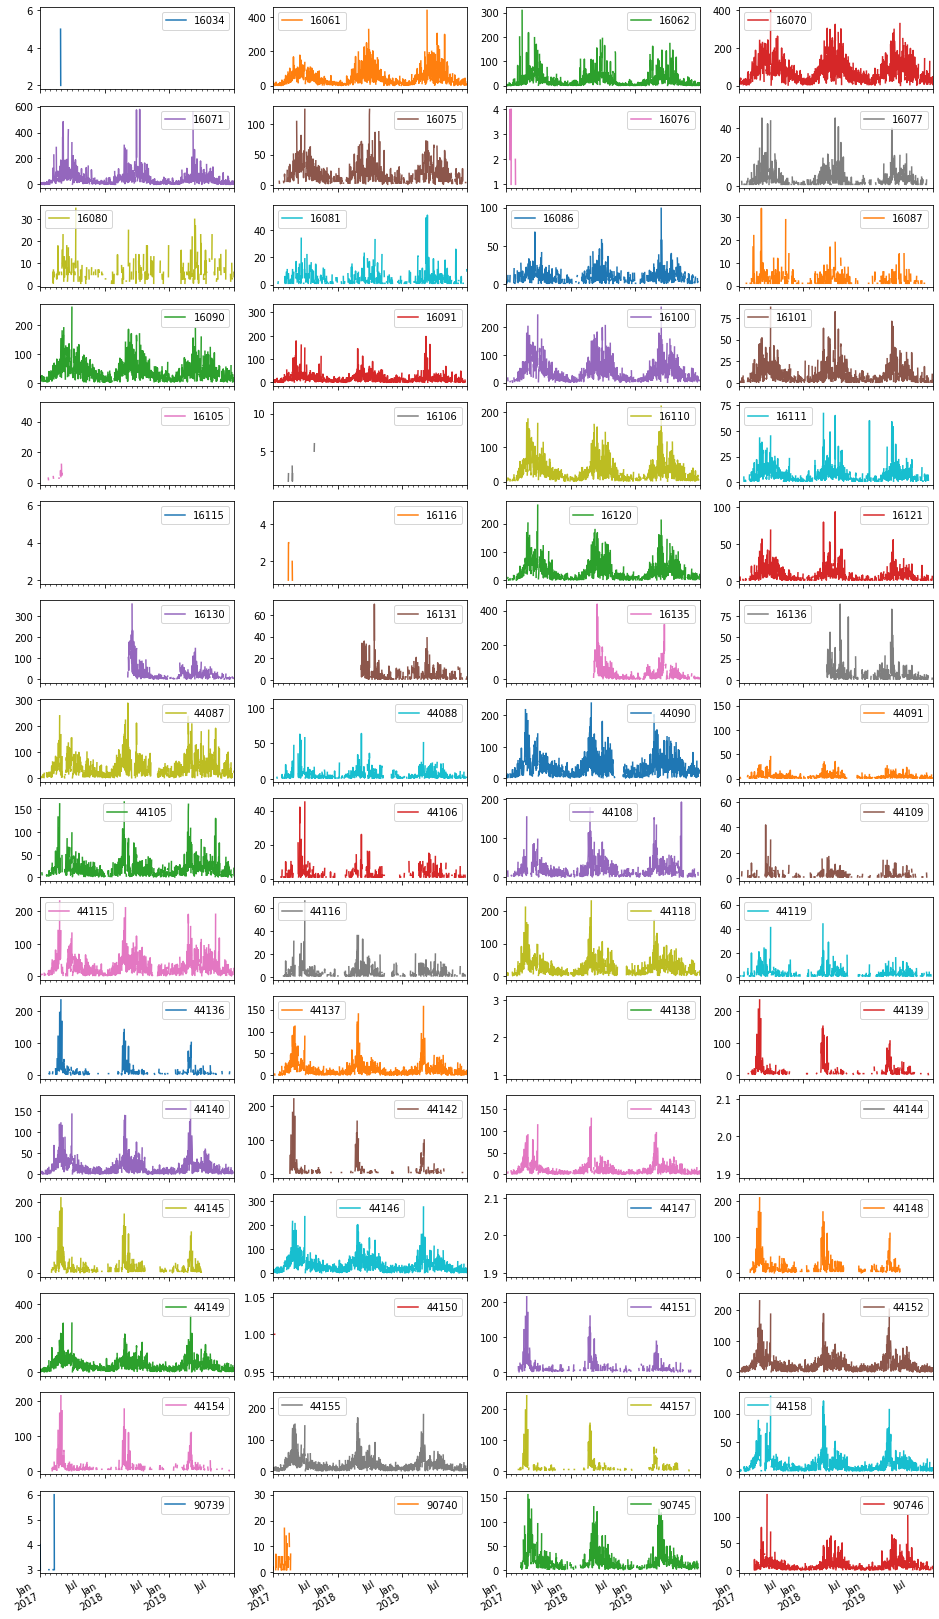

In [12]:
utils.plot_grid(u_producto, n_cols=4, figsize=(16,32))

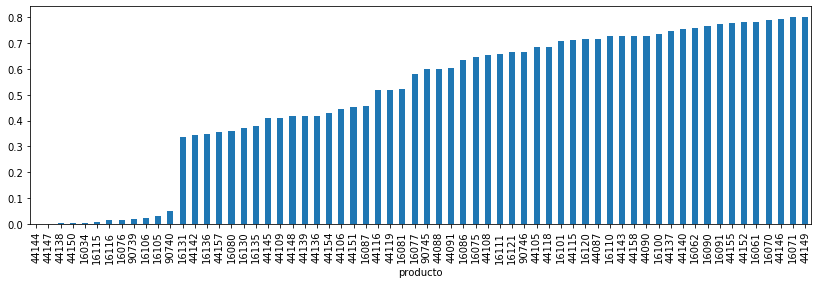

In [13]:
utils.get_amount_info(u_producto).plot(kind="bar")

In [14]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=6)

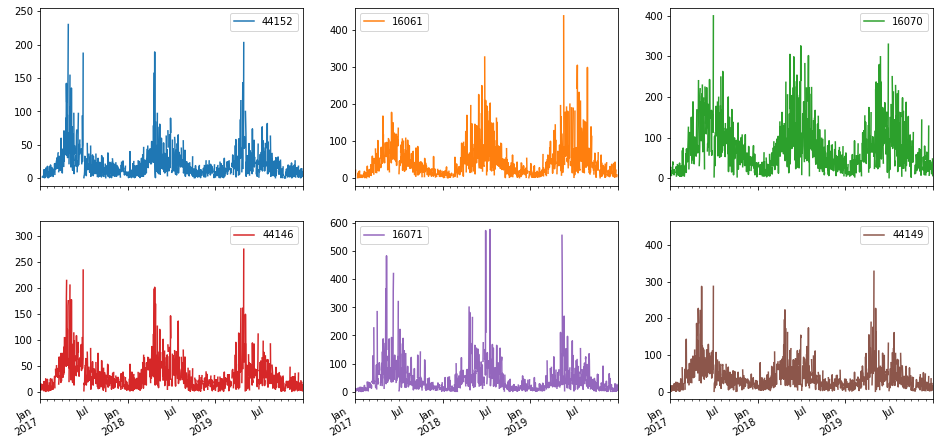

In [15]:
utils.plot_grid(u_producto_forecastable, n_cols=3, figsize=(16, 8))

In [72]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

### Prophet

In [64]:
from forecaster import ProphetForecaster

In [18]:
model = ProphetForecaster(yearly_seasonality=10)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [19]:
fcst.head(10)

16061                            16070                        \
                yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper   
ds                                                                            
2017-01-02  7.607492   2.147033  19.107275  18.882908   5.221404  49.709398   
2017-01-03  7.655358   2.044572  21.848243  18.468423   4.711365  48.595016   
2017-01-04       NaN        NaN        NaN  18.132702   4.991626  47.278824   
2017-01-05  7.752606   2.116462  24.391939  17.871038   4.680275  44.447420   
2017-01-06       NaN        NaN        NaN  17.677949   4.815235  50.092582   
2017-01-07  7.819204   2.023210  20.793145  17.547252   5.315287  47.953466   
2017-01-08       NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN        NaN        NaN        NaN   
2017-01-10       NaN        NaN        NaN  17.458311   5.133660  44.601125   
2017-01-11  7.730956   2.056435  20.368086  17.503271   4.749680  45.327487   

               16071                           44146                        \
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.443757   1.951019  22.240232  8.136911   2.555216  20.736360   
2017-01-03  7.226782   2.155876  22.622711  7.933868   2.541136  19.631344   
2017-01-04  7.029426   1.846975  23.121213  7.758169   2.335649  20.395444   
2017-01-05  6.852098   1.840635  21.075162  7.610907   2.266860  19.814214   
2017-01-06       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-07  6.557927   1.824217  20.844494  7.404455   2.362101  19.419638   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09  6.342950   1.534266  20.733710       NaN        NaN        NaN   
2017-01-10  6.263923   1.647288  20.686896  7.317735   2.278142  18.056766   
2017-01-11  6.202888   1.767916  20.124670  7.347116   2.412771  19.320654   

               44149                           44152                        
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper  
ds                                                                          
2017-01-02  9.402126   2.869995  25.165590       NaN        NaN        NaN  
2017-01-03  9.200642   2.418375  27.052711       NaN        NaN        NaN  
2017-01-04  9.033849   2.509082  24.820871       NaN        NaN        NaN  
2017-01-05  8.901382   2.507794  24.811185       NaN        NaN        NaN  
2017-01-06  8.802618   2.378118  23.616921       NaN        NaN        NaN  
2017-01-07  8.736705   2.512198  26.326884       NaN        NaN        NaN  
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN  
2017-01-10  8.724281   2.446812  24.670043       NaN        NaN        NaN  
2017-01-11  8.776896   2.496863  24.442878  4.718857    1.35965  14.763664

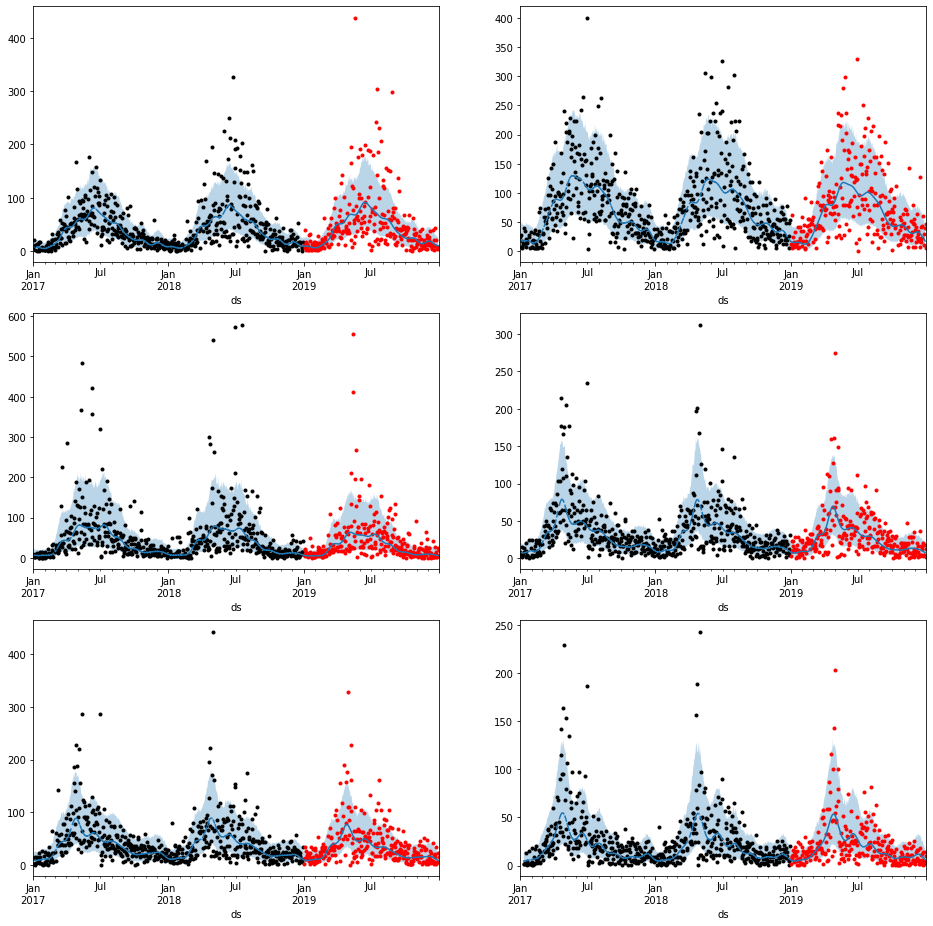

In [21]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [22]:
error_prophet = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test

In [24]:
mae_prophet = error_prophet.abs().mean()
mae_prophet

16061    26.650334
16070    34.349628
16071    23.811010
44146    15.362168
44149    19.649424
44152    11.610531
dtype: float64

In [43]:
mae_prophet.mean()

21.90551568820652

##### With Regressors

In [170]:
from forecaster import ProphetForecaster

In [171]:
indicador = pd.read_csv("../data/indicador_económico.csv")

In [172]:
indicador = indicador.set_index("fecha")

In [173]:
model = ProphetForecaster(yearly_seasonality=10)
model.fit(train, indicador)
fcst = model.predict(steps=365, regressors=indicador).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


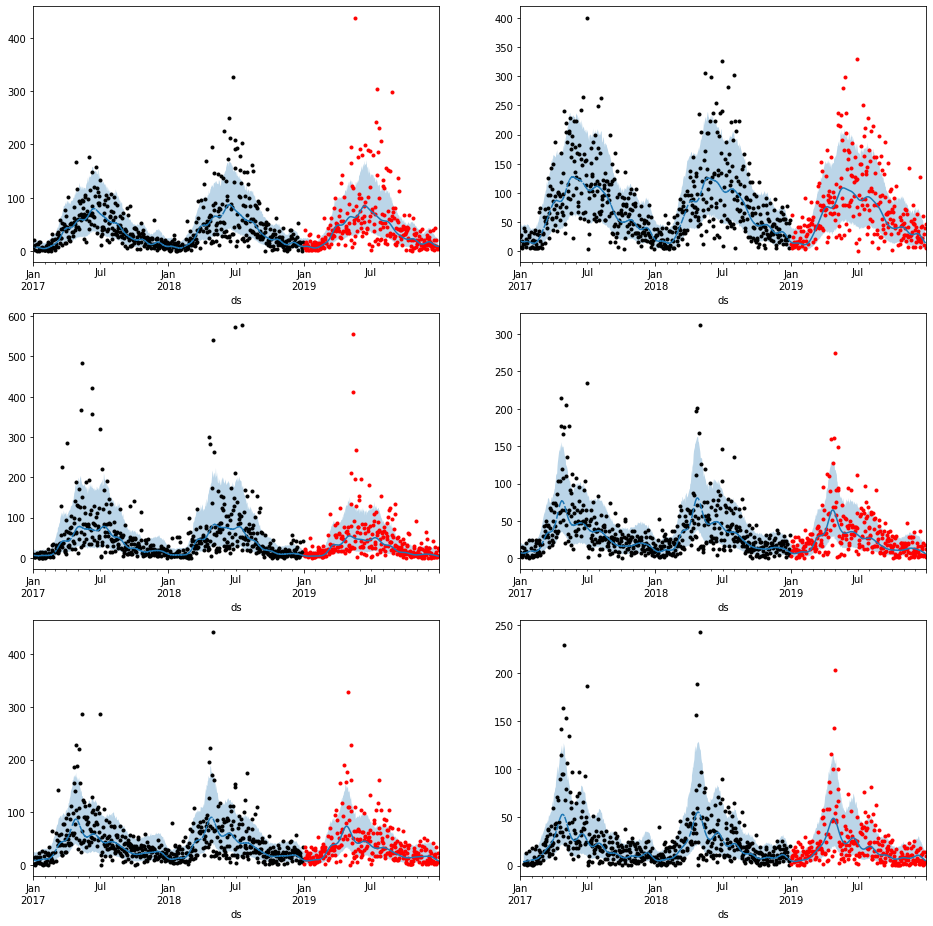

In [174]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [175]:
error_prophet_reg = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test

In [176]:
mae_prophet_reg = error_prophet_reg.abs().mean()
mae_prophet_reg

16061    26.529938
16070    35.042257
16071    24.323758
44146    15.620693
44149    19.804124
44152    11.507714
dtype: float64

In [177]:
mae_prophet_reg.mean()

22.13808067669728

##### WIth holidays

In [154]:
model = ProphetForecaster(country_holidays="AR", yearly_seasonality=10)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


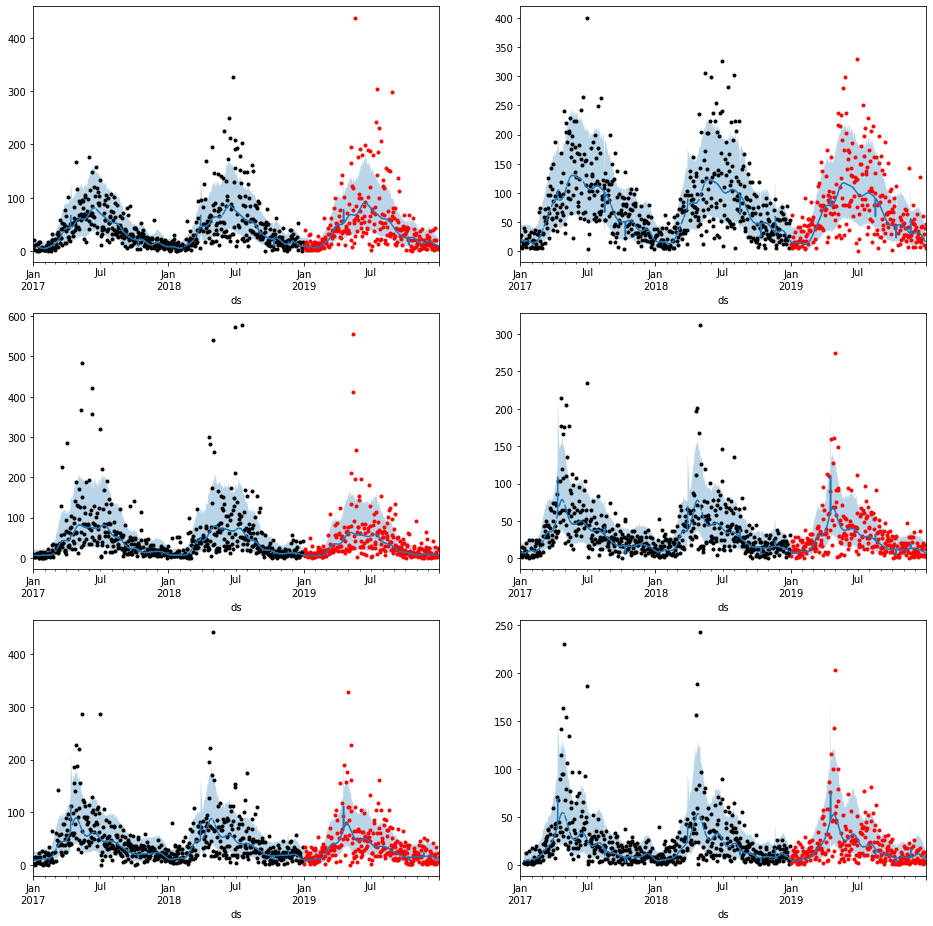

In [155]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [159]:
error_prophet_hol = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test

In [160]:
mae_prophet_hol = error_prophet_hol.abs().mean()
mae_prophet_hol

16061    26.535045
16070    34.453734
16071    23.818956
44146    15.251901
44149    19.415214
44152    11.507173
dtype: float64

In [161]:
mae_prophet_hol.mean()

21.830336999080444

### ARIMA

In [67]:
from forecaster import ARIMAForecaster

In [68]:
model = ARIMAForecaster()
model.fit(train)
fcst = model.predict(365)

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [69]:
fcst.head(10)

44152                           16061                        \
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
2019-01-01  5.610312   1.863951  14.906400  8.844467   2.886348  22.272293   
2019-01-02  3.938830   1.226000  11.012163  8.836211   2.883019  22.254834   
2019-01-03  3.604491   1.107513  10.178921  8.834330   2.882260  22.250857   
2019-01-04  4.028328   1.246324  11.315113  8.833912   2.882092  22.249972   
2019-01-05  4.426788   1.380743  12.356490  8.830068   2.880542  22.241843   
2019-01-06  4.434203   1.382940  12.377991  8.818091   2.875713  22.216510   
2019-01-07  4.229539   1.309993  11.870341  8.793622   2.865852  22.164740   
2019-01-08  3.991969   1.225705  11.279295  8.752824   2.849421  22.078380   
2019-01-09  3.831378   1.169234  10.876770  8.692549   2.825174  21.950695   
2019-01-10  3.751256   1.141222  10.674973  8.610484   2.792214  21.776667   

                16070                            44146                        \
                 yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper   
2019-01-01  23.047420   7.535104  54.259896  12.444384   4.504883  29.544891   
2019-01-02  20.023722   6.153331  48.856621  10.225256   3.507979  25.230683   
2019-01-03  19.537596   5.948147  47.924097   9.824683   3.343335  24.382504   
2019-01-04  19.116768   5.771664  47.113877   9.443966   3.187898  23.572519   
2019-01-05  18.759386   5.622640  46.423593   9.087350   3.043263  22.810234   
2019-01-06  18.462698   5.499531  45.848949   8.758416   2.910715  22.103902   
2019-01-07  18.223150   5.400540  45.383904   8.460083   2.791238  21.460479   
2019-01-08  18.036479   5.323657  45.020834   8.194630   2.685543  20.885633   
2019-01-09  17.897794   5.266685  44.750705   7.963753   2.594101  20.383795   
2019-01-10  17.801652   5.227264  44.563244   7.768621   2.517179  19.958252   

                16071                            44149                        
                 yhat yhat_lower yhat_upper       yhat yhat_lower yhat_upper  
2019-01-01  14.021466   4.493182  38.562175  14.877593   5.058075  36.178896  
2019-01-02  11.100428   3.383485  31.753886  12.583454   4.045060  31.772726  
2019-01-03   9.604403   2.854448  28.021480  11.929210   3.781779  30.400108  
2019-01-04   8.924191   2.623508  26.258768  11.530368   3.623591  29.553665  
2019-01-05   8.446119   2.463197  25.006772  11.193755   3.490988  28.836027  
2019-01-06   8.060103   2.334710  23.989842  10.891437   3.372600  28.188977  
2019-01-07   7.720177   2.222233  23.090187  10.620091   3.266924  27.606112  
2019-01-08   7.414207   2.121543  22.276974  10.379915   3.173860  27.088485  
2019-01-09   7.138447   2.031259  21.541142  10.171424   3.093442  26.637796  
2019-01-10   6.891984   1.950953  20.881042   9.994975   3.025657  26.255369

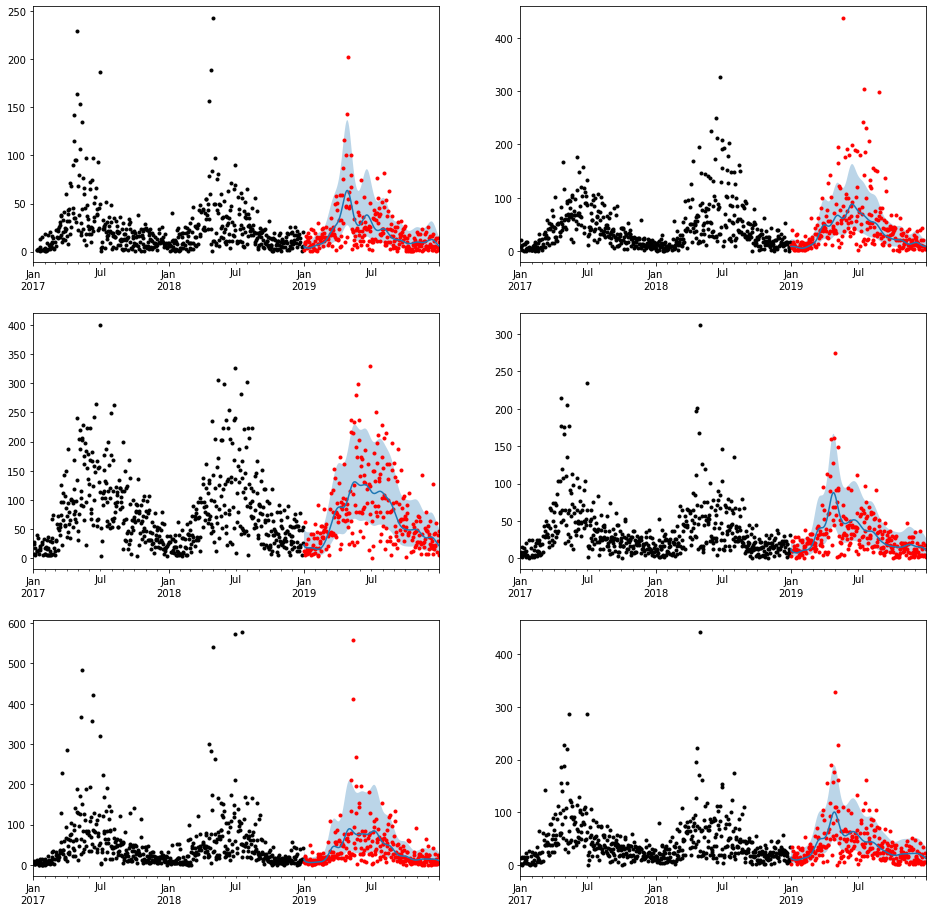

In [70]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [71]:
error_arima = fcst.loc[:, pd.IndexSlice[:,"yhat"]].droplevel(1, axis=1) - test
mae_arima = error_arima.abs().mean().mean()
mae_arima

22.16739330886189

# Forecast por producto y región

In [76]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

In [77]:
u_producto_region = u_producto_region.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [78]:
u_producto_region.head()

producto      16034   16061            16062            16070           \
sucursal   santa fe neuquen santa fe neuquen santa fe neuquen santa fe   
2017-01-01      NaN     NaN      NaN     NaN      NaN     NaN      NaN   
2017-01-02      NaN     NaN      7.0     NaN      1.0     NaN     25.0   
2017-01-03      NaN     NaN     21.0     NaN      NaN     NaN     27.0   
2017-01-04      NaN     NaN      NaN     NaN      NaN     NaN      8.0   
2017-01-05      NaN     NaN      3.0     NaN      NaN     NaN      6.0   

producto     16071            16075  ...   44158            90739           \
sucursal   neuquen santa fe neuquen  ... neuquen santa fe neuquen santa fe   
2017-01-01     NaN      NaN     NaN  ...     NaN      NaN     NaN      NaN   
2017-01-02     NaN     11.0     NaN  ...     NaN      NaN     NaN      4.0   
2017-01-03     NaN      2.0     NaN  ...     NaN      NaN     NaN      3.0   
2017-01-04     NaN      4.0     NaN  ...     NaN      1.0     NaN      NaN   
2017-01-05     NaN      3.0     NaN  ...     NaN      1.0     NaN      NaN   

producto     90740            90745            90746           
sucursal   neuquen santa fe neuquen santa fe neuquen santa fe  
2017-01-01     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-02     NaN      1.0     NaN      NaN     NaN      NaN  
2017-01-03     NaN      2.0     NaN      NaN     NaN      NaN  
2017-01-04     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-05     NaN      1.0     NaN      NaN     NaN      NaN  

[5 rows x 120 columns]

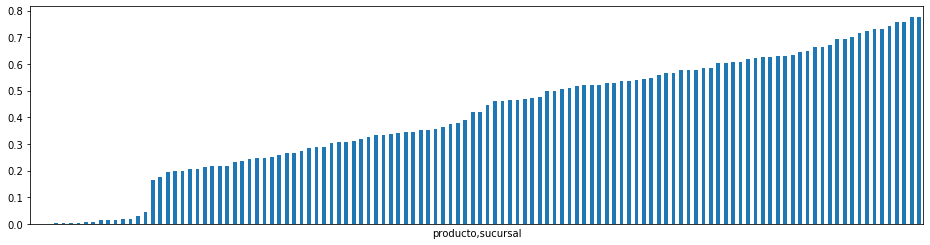

In [79]:
utils.get_amount_info(u_producto_region).plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

In [80]:
u_producto_region_forecastable = utils.get_forecastables(u_producto_region, T=0.5, N=12).sort_index(axis=1)

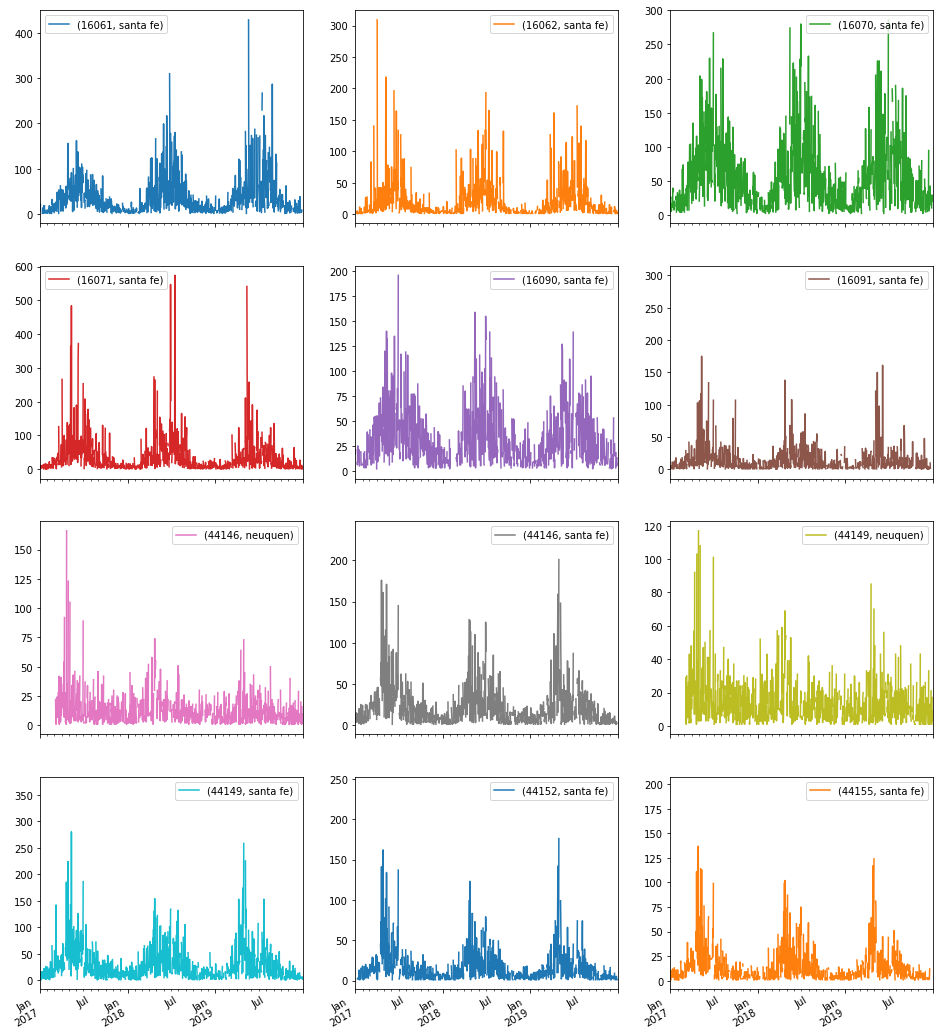

In [81]:
utils.plot_grid(u_producto_region_forecastable, n_cols=3, figsize=(16, 20))

In [82]:
train, test = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

### Prophet

In [83]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [84]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.519911  16.718836  2.229475   0.714846   7.416428   
2017-01-03  5.406998   1.486957  15.177959       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.523990  15.567870       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.716911   7.172256   
2017-01-07  5.456751   1.632894  16.616715       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN  2.358351   0.724658   7.280400   
2017-01-10       NaN        NaN        NaN  2.370805   0.768433   7.300094   
2017-01-11  5.395641   1.472951  16.582660  2.379988   0.726485   7.910195   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.400177  40.947193  5.567765  ...        NaN   
2017-01-03  14.656313   4.272611  39.497418  5.496262  ...        NaN   
2017-01-04  14.414836   4.302857  39.777223  5.432328  ...        NaN   
2017-01-05  14.227067   4.500825  38.440916  5.375307  ...        NaN   
2017-01-06  14.089813   4.244959  38.064549       NaN  ...        NaN   
2017-01-07  13.999225   4.194383  39.417114  5.279075  ...        NaN   
2017-01-08        NaN        NaN        NaN       NaN  ...        NaN   
2017-01-09        NaN        NaN        NaN  5.201425  ...        NaN   
2017-01-10  13.960102   4.228598  37.931643  5.167639  ...        NaN   
2017-01-11  14.006174   3.724037  37.547420  5.136246  ...        NaN   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.859500   2.006633  28.175332       NaN        NaN        NaN   
2017-01-03  7.707466   1.988707  25.298933       NaN        NaN        NaN   
2017-01-04  7.570713   1.884751  24.728677       NaN        NaN        NaN   
2017-01-05  7.449867   1.964917  23.741569       NaN        NaN        NaN   
2017-01-06  7.345328   1.880127  22.935387       NaN        NaN        NaN   
2017-01-07  7.257265   1.856766  23.218453       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-10  7.090192   1.656853  22.984187       NaN        NaN        NaN   
2017-01-11  7.065153   1.923090  23.253937  3.503355   1.065344  10.967287   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.292983  11.890580  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.265298  12.543543  
2017-01-05  3.942978   1.279841  13.097970  
2017-01-06       NaN        NaN        NaN  
2017-01-07  3.979607   1.323666  12.736307  
2017-01-08       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN  
2017-01-10  3.954297   1.385121  13.079898  
2017-01-11  3.923883   1.275527  11.955542  

[10 rows x 36 columns]

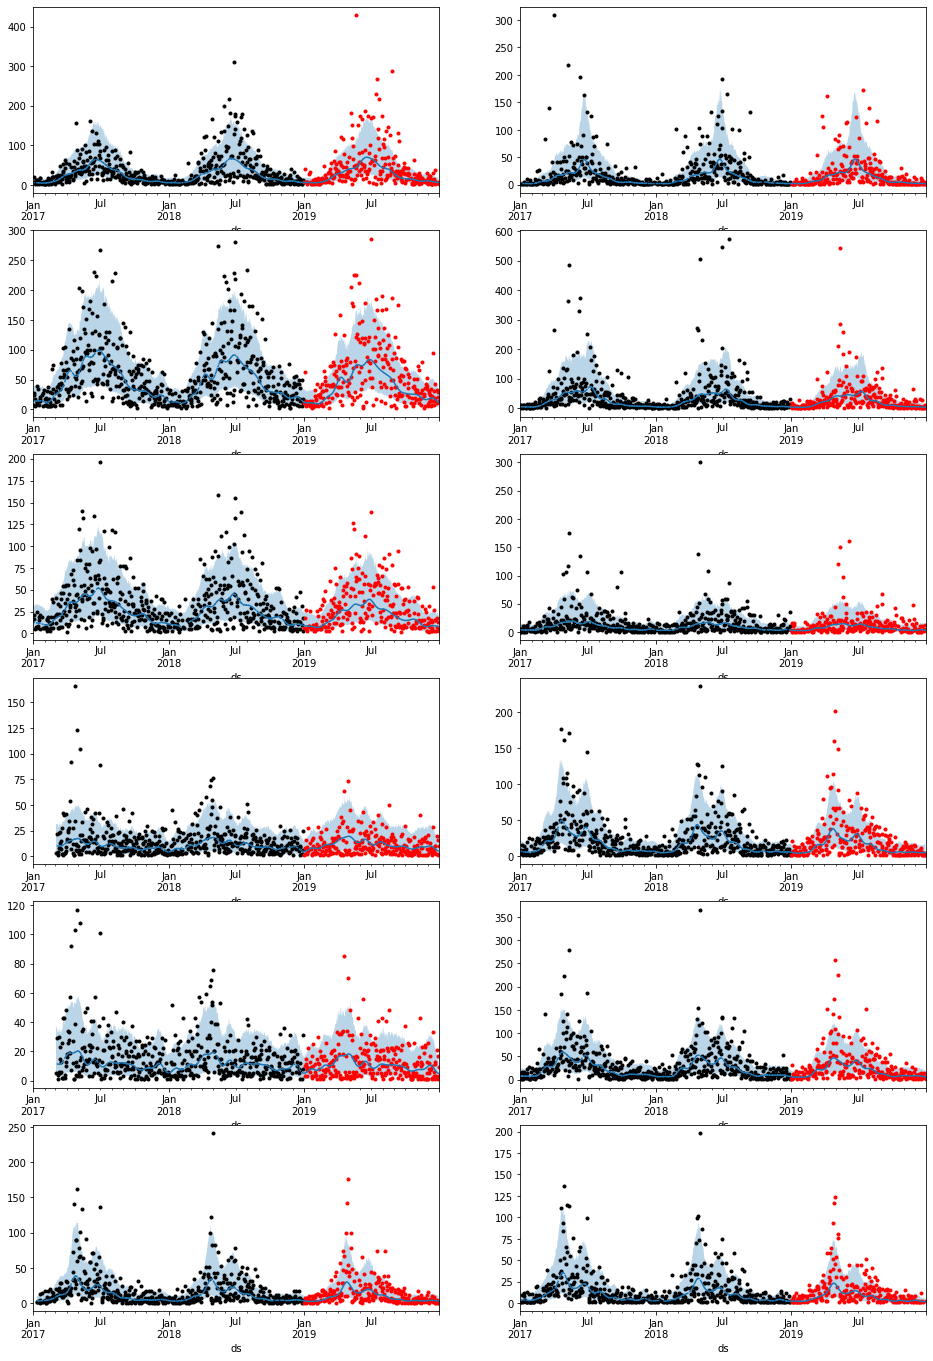

In [85]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

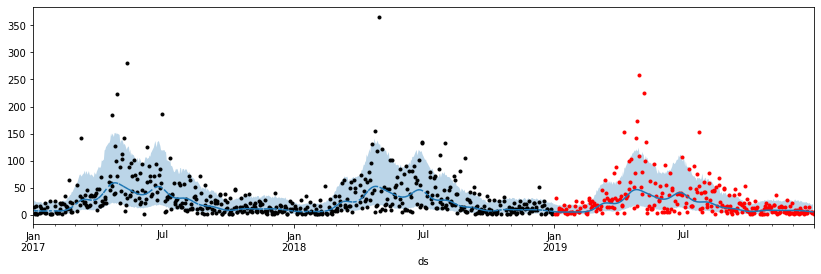

In [86]:
item = (44149, "santa fe")
utils.plot_fcst(fcst[item], train[item], test[item])

In [87]:
error_prophet = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae_prophet = error_prophet.abs().mean().mean()
mae_prophet

14.927661483012391

### ARIMA

In [ ]:
model = ARIMAForecaster()
model.fit(train)
fcst = model.predict(365)

In [ ]:
fcst.head(10)

In [ ]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [ ]:
error_arima = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :, "yhat"]].droplevel(2, axis=1).mean() - test
mae_arima = error_arima.abs().mean().mean()
mae_arima